In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
tf.set_random_seed(77)
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac12.csv', sep=',',header=None,names=columns )
sales=list(txs['sales'])
forecastDay=1
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

In [2]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month

week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]
day_of_week01s=[0,0,0,0,0,1,1]
day_of_week01= lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d" ).weekday())]
txs['season']=txs['date'].map(season)
txs['day_of_week01']=txs['date'].map(day_of_week01)

originalSales=list(txs['sales'])
sales=list(txs['sales'])

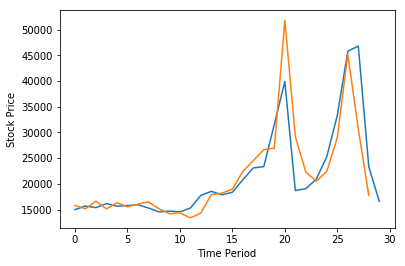

In [3]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [4]:
print(i for i in list(test_predict[-1]    ))

<generator object <genexpr> at 0x000000000CA1B1A8>


In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY